In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

# Data Analysis

In [2]:
data  = pd.read_csv('AirQuality.csv')
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# Check for null values
data.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [4]:
data.dropna(inplace=True)

In [5]:
# Convert Columns into dateTime format
dateTime = data[['year','month','day','hour']]
data['Time'] = pd.to_datetime(dateTime)

In [6]:
# Select only PM 2.5 as the data and set Time as index.
data = data[['pm2.5','Time']]
data.set_index('Time',inplace=True)

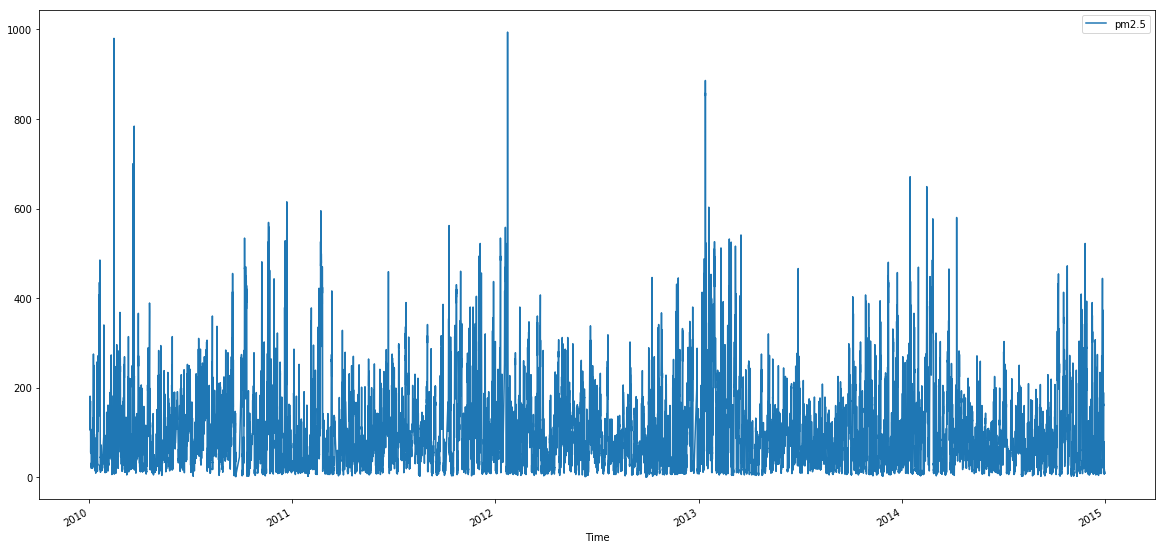

In [7]:
# Daily Air quality reading. 
data.plot(figsize=(20,10))

In [8]:
#train = data[:'2013']
#test = data['2014':]

In [9]:
# Take daily and monthly average 
daily_avg = data['pm2.5'].resample('D').mean()
monthly_avg = data['pm2.5'].resample('MS').mean()

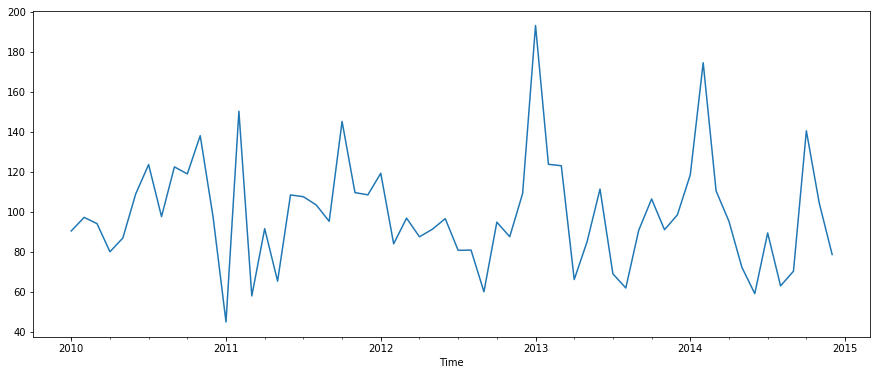

In [41]:
monthly_avg.plot(figsize=(15,6))

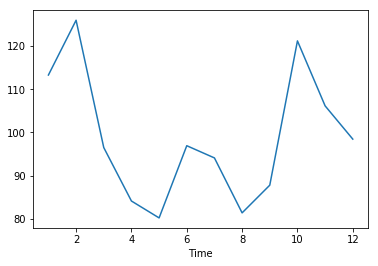

In [11]:
# Monthly average.
monthly_avg.groupby(monthly_avg.index.month).mean().plot()

In [43]:
train = monthly_avg[:'2013']
test = monthly_avg['2014':]

In [44]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    timeseries.plot(color='blue',label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

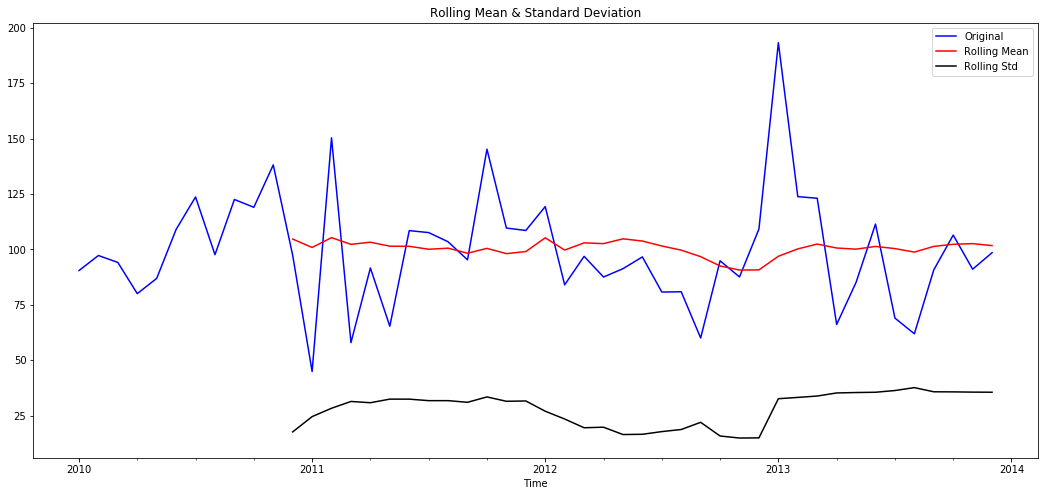

Results of Dickey-Fuller Test:
Test Statistic                 -4.349020
p-value                         0.000365
#Lags Used                      9.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [45]:
test_stationarity(train)

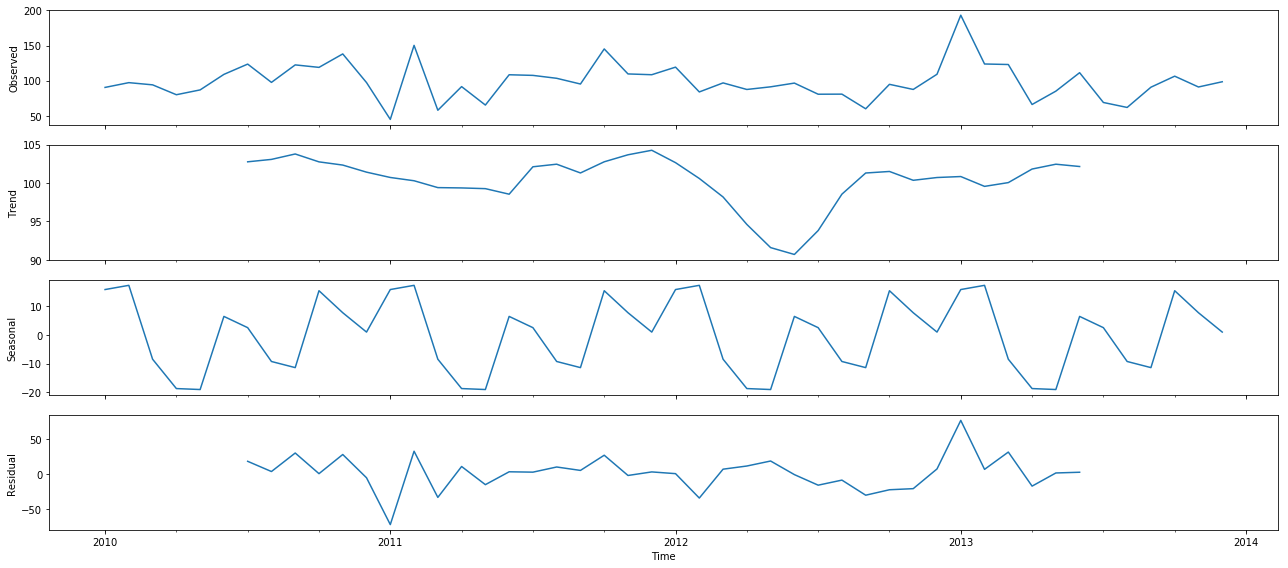

In [46]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(train, model='additive')
fig = decomposition.plot()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial AutoCorrelation Function')

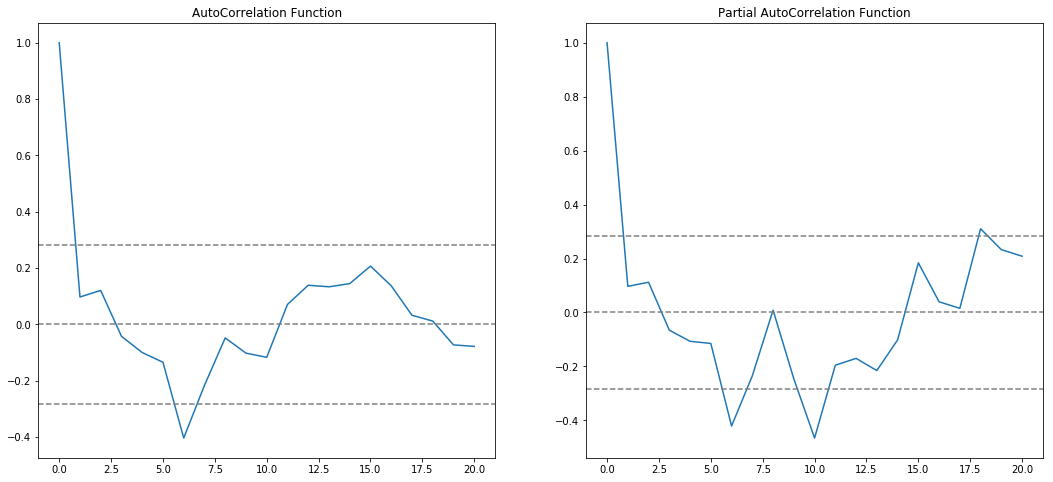

In [47]:
# ACF and PACF

lag_acf = acf(train,nlags=20)
lag_pacf = pacf(train,nlags=20,method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.title('AutoCorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.title('Partial AutoCorrelation Function')

In [64]:
# AR Model
model = ARIMA(train,order=(2,1,2))
results_AR = model.fit(disp=-1)
# plt.plot(daily_avg)
# plt.plot(results_AR.fittedvalues,color='red')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [65]:
results_AR.forecast(12)

(array([97.81612241, 95.02363062, 97.18564617, 94.82473489, 96.89680085,
        94.6573628 , 96.6146838 , 94.48728656, 96.33559383, 94.31430463,
        96.05933617, 94.13856641]),
 array([25.75341099, 25.96830948, 25.97036037, 25.97770269, 25.98396166,
        25.98995745, 25.99562939, 26.00100215, 26.00609086, 26.01091065,
        26.01547579, 26.01979976]),
 array([[ 47.34036439, 148.29188042],
        [ 44.1266793 , 145.92058195],
        [ 46.28467518, 148.08661716],
        [ 43.90937321, 145.74009657],
        [ 45.96917181, 147.82442989],
        [ 43.71798224, 145.59674337],
        [ 45.66418644, 147.56518116],
        [ 43.52625878, 145.44831434],
        [ 45.36459237, 147.30659529],
        [ 43.33385654, 145.29475272],
        [ 45.06994059, 147.04873175],
        [ 43.140696  , 145.13643682]]))

                             ARIMA Model Results                              
Dep. Variable:                D.pm2.5   No. Observations:                   47
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -221.446
Method:                       css-mle   S.D. of innovations             25.753
Date:                Thu, 26 Dec 2019   AIC                            454.892
Time:                        12:31:48   BIC                            465.993
Sample:                    02-01-2010   HQIC                           459.070
                         - 12-01-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1127      0.301     -0.374      0.710      -0.703       0.477
ar.L1.D.pm2.5    -0.8705      0.148     -5.880      0.000      -1.161      -0.580
ar.L2.D.pm2.5     0.1000      0.148     

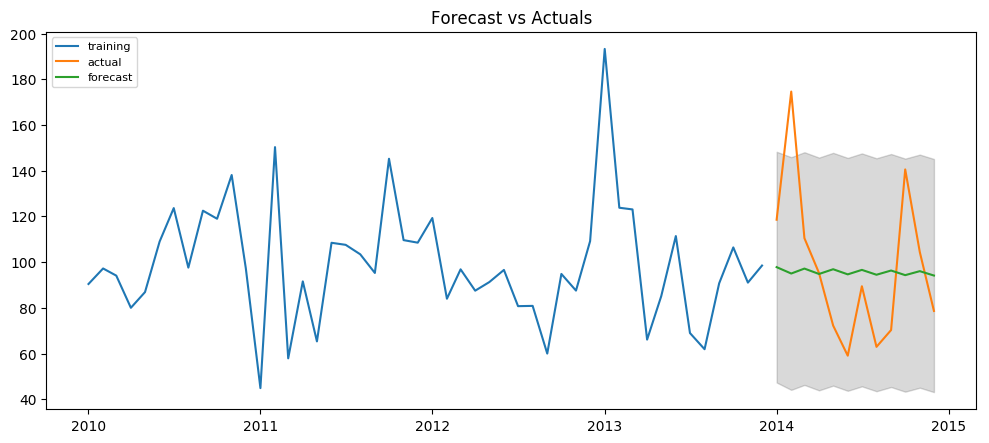

In [66]:
print(results_AR.summary())

# Forecast
fc, se, conf = results_AR.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Since there's no constant seasonality we don't get exact forecast but the ARIMA model predicts the overall average for the future.